## Load and Prepare Data



In [28]:
import pandas as pd
sentiment = pd.read_csv('/content/fear_greed_index.csv')
trades = pd.read_csv('/content/historical_data.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')
trades = trades.rename(columns={'Closed PnL': 'closedPnL'})

print("Data loaded and preprocessed successfully.")
print("Sentiment DataFrame head:")
print(sentiment.head())
print("\nTrades DataFrame head:")
print(trades.head())

Data loaded and preprocessed successfully.
Sentiment DataFrame head:
    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05

Trades DataFrame head:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024

## Merge Datasets




In [29]:
trades['trade_date'] = trades['Timestamp IST'].dt.date

print("Added 'trade_date' column to trades DataFrame.")
print(trades[['Timestamp IST', 'trade_date']].head())

Added 'trade_date' column to trades DataFrame.
        Timestamp IST  trade_date
0 2024-12-02 22:50:00  2024-12-02
1 2024-12-02 22:50:00  2024-12-02
2 2024-12-02 22:50:00  2024-12-02
3 2024-12-02 22:50:00  2024-12-02
4 2024-12-02 22:50:00  2024-12-02


In [30]:
import pandas as pd


trades['trade_date'] = pd.to_datetime(trades['trade_date'])


data = pd.merge(trades, sentiment, left_on='trade_date', right_on='date', how='left')

print("Merged DataFrame 'data' created successfully.")
print(data.head())

Merged DataFrame 'data' created successfully.
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-12-02 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-12-02 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-12-02 22:50:00     1289.488521       Buy   

   closedPnL  ...     Order ID  Crossed       

## Feature Engineering



In [31]:
import numpy as np
data['is_profitable'] = data['closedPnL'] > 0
data['abs_pnl'] = data['closedPnL'].abs()
if 'leverage' in data.columns:
    data['risk_adjusted_pnl'] = np.where(data['leverage'] != 0, data['closedPnL'] / data['leverage'], 0)
else:
    print("Warning: 'leverage' column not found. 'risk_adjusted_pnl' cannot be calculated. Setting to 0 for now.")

    data['risk_adjusted_pnl'] = 0



if 'Size USD' in data.columns:
    data['trade_size_usd'] = data['Size USD']
    print("Using existing 'Size USD' column as 'trade_size_usd'.")
elif 'Size Tokens' in data.columns and 'Execution Price' in data.columns:
    data['trade_size_usd'] = data['Size Tokens'] * data['Execution Price']
    print("Created 'trade_size_usd' by multiplying 'Size Tokens' and 'Execution Price'.")
else:
    data['trade_size_usd'] = np.nan
    print("Could not determine 'trade_size_usd'. 'Size Tokens' or 'Execution Price' columns are missing.")

print("New features 'is_profitable', 'abs_pnl', 'risk_adjusted_pnl', and 'trade_size_usd' created successfully.")
print(data[['closedPnL', 'is_profitable', 'abs_pnl', 'risk_adjusted_pnl', 'trade_size_usd']].head())

Using existing 'Size USD' column as 'trade_size_usd'.
New features 'is_profitable', 'abs_pnl', 'risk_adjusted_pnl', and 'trade_size_usd' created successfully.
   closedPnL  is_profitable  abs_pnl  risk_adjusted_pnl  trade_size_usd
0        0.0          False      0.0                  0         7872.16
1        0.0          False      0.0                  0          127.68
2        0.0          False      0.0                  0         1150.63
3        0.0          False      0.0                  0         1142.04
4        0.0          False      0.0                  0           69.75


## Analyze Performance Metrics by Sentiment




In [32]:
performance_summary = data.groupby('classification').agg(
    avg_pnl=('closedPnL', 'mean'),
    median_pnl=('closedPnL', 'median'),
    avg_trade_size=('trade_size_usd', 'mean'),
    trade_count=('closedPnL', 'size')
).reset_index()


win_rate = data.groupby('classification')['is_profitable'].mean() * 100
performance_summary = performance_summary.merge(win_rate.rename('win_rate'), on='classification')


performance_summary = performance_summary[['classification', 'avg_pnl', 'median_pnl', 'win_rate', 'avg_trade_size', 'trade_count']]

print("Performance metrics by sentiment classification:")
print(performance_summary)

Performance metrics by sentiment classification:
  classification    avg_pnl  median_pnl   win_rate  avg_trade_size  \
0   Extreme Fear  34.537862         0.0  37.060748     5349.731843   
1  Extreme Greed  67.892861         0.0  46.494299     3112.251565   
2           Fear  54.290400         0.0  42.076750     7816.109931   
3          Greed  42.743559         0.0  38.482794     5736.884375   
4        Neutral  34.307718         0.0  39.699093     4782.732661   

   trade_count  
0        21400  
1        39992  
2        61837  
3        50303  
4        37686  


## Analyze Risk Metrics by Sentiment




In [33]:
risk_summary = data.groupby('classification').agg(
    avg_abs_pnl=('abs_pnl', 'mean'),
    max_loss=('closedPnL', 'min'),
    avg_risk_adjusted_pnl=('risk_adjusted_pnl', 'mean')
).reset_index()

print("Risk metrics by sentiment classification:")
print(risk_summary)

Risk metrics by sentiment classification:
  classification  avg_abs_pnl      max_loss  avg_risk_adjusted_pnl
0   Extreme Fear    94.007169  -31036.69194                    0.0
1  Extreme Greed    81.440567  -10259.46800                    0.0
2           Fear    73.489062  -35681.74723                    0.0
3          Greed    84.835917 -117990.10410                    0.0
4        Neutral    54.967150  -24500.00000                    0.0


## Visualize Results

### Subtask:
Generate visualizations to illustrate the relationship between market sentiment and both trader performance and risk. Create bar charts or other suitable plots to compare average PnL, win rate, average absolute PnL, max loss, and average risk-adjusted PnL across different sentiment categories. Ensure all plots include clear legends.


**Reasoning**:
I will import the necessary plotting libraries, `matplotlib.pyplot` and `seaborn`, to generate the requested visualizations.



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries matplotlib.pyplot and seaborn imported.")

Libraries matplotlib.pyplot and seaborn imported.


**Reasoning**:
I will generate bar charts for average PnL, win rate, average absolute PnL, maximum loss, and average risk-adjusted PnL across different sentiment classifications using `performance_summary` and `risk_summary` DataFrames to visualize the relationship between market sentiment and trader performance/risk.



/tmp/ipython-input-1852436650.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='avg_pnl', data=performance_summary, palette='viridis')
/tmp/ipython-input-1852436650.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='win_rate', data=performance_summary, palette='magma')
/tmp/ipython-input-1852436650.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='avg_abs_pnl', data=risk_summary, palette='cividis')
/tmp/ipython-input-1852436650.py:26: FutureWarning: 

Passing `palett

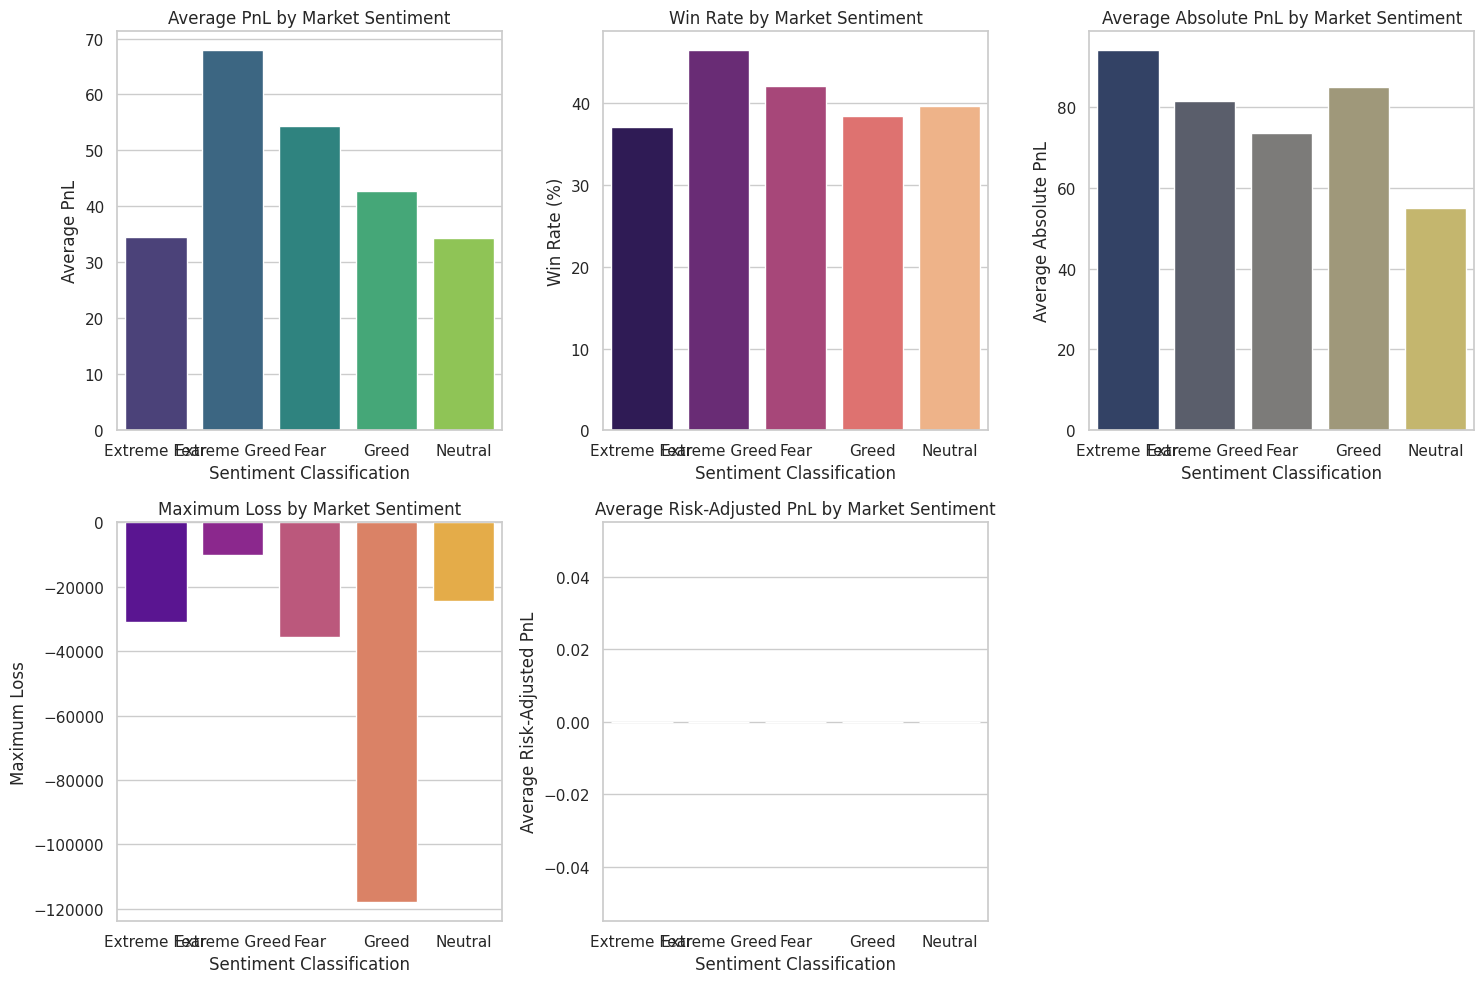

Visualizations generated successfully.


In [35]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.barplot(x='classification', y='avg_pnl', data=performance_summary, palette='viridis')
plt.title('Average PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average PnL')


plt.subplot(2, 3, 2)
sns.barplot(x='classification', y='win_rate', data=performance_summary, palette='magma')
plt.title('Win Rate by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Win Rate (%)')

plt.subplot(2, 3, 3)
sns.barplot(x='classification', y='avg_abs_pnl', data=risk_summary, palette='cividis')
plt.title('Average Absolute PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Absolute PnL')


plt.subplot(2, 3, 4)
sns.barplot(x='classification', y='max_loss', data=risk_summary, palette='plasma')
plt.title('Maximum Loss by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Maximum Loss')


plt.subplot(2, 3, 5)
sns.barplot(x='classification', y='avg_risk_adjusted_pnl', data=risk_summary, palette='coolwarm')
plt.title('Average Risk-Adjusted PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Risk-Adjusted PnL')

plt.tight_layout()
plt.show()

print("Visualizations generated successfully.")

**Reasoning**:
The previous code generated `FutureWarning` messages from Seaborn regarding the use of `palette` without assigning `hue`. To suppress these warnings and align with best practices for future Seaborn versions, I will modify each `sns.barplot` call to explicitly set `hue='classification'` and `legend=False`.



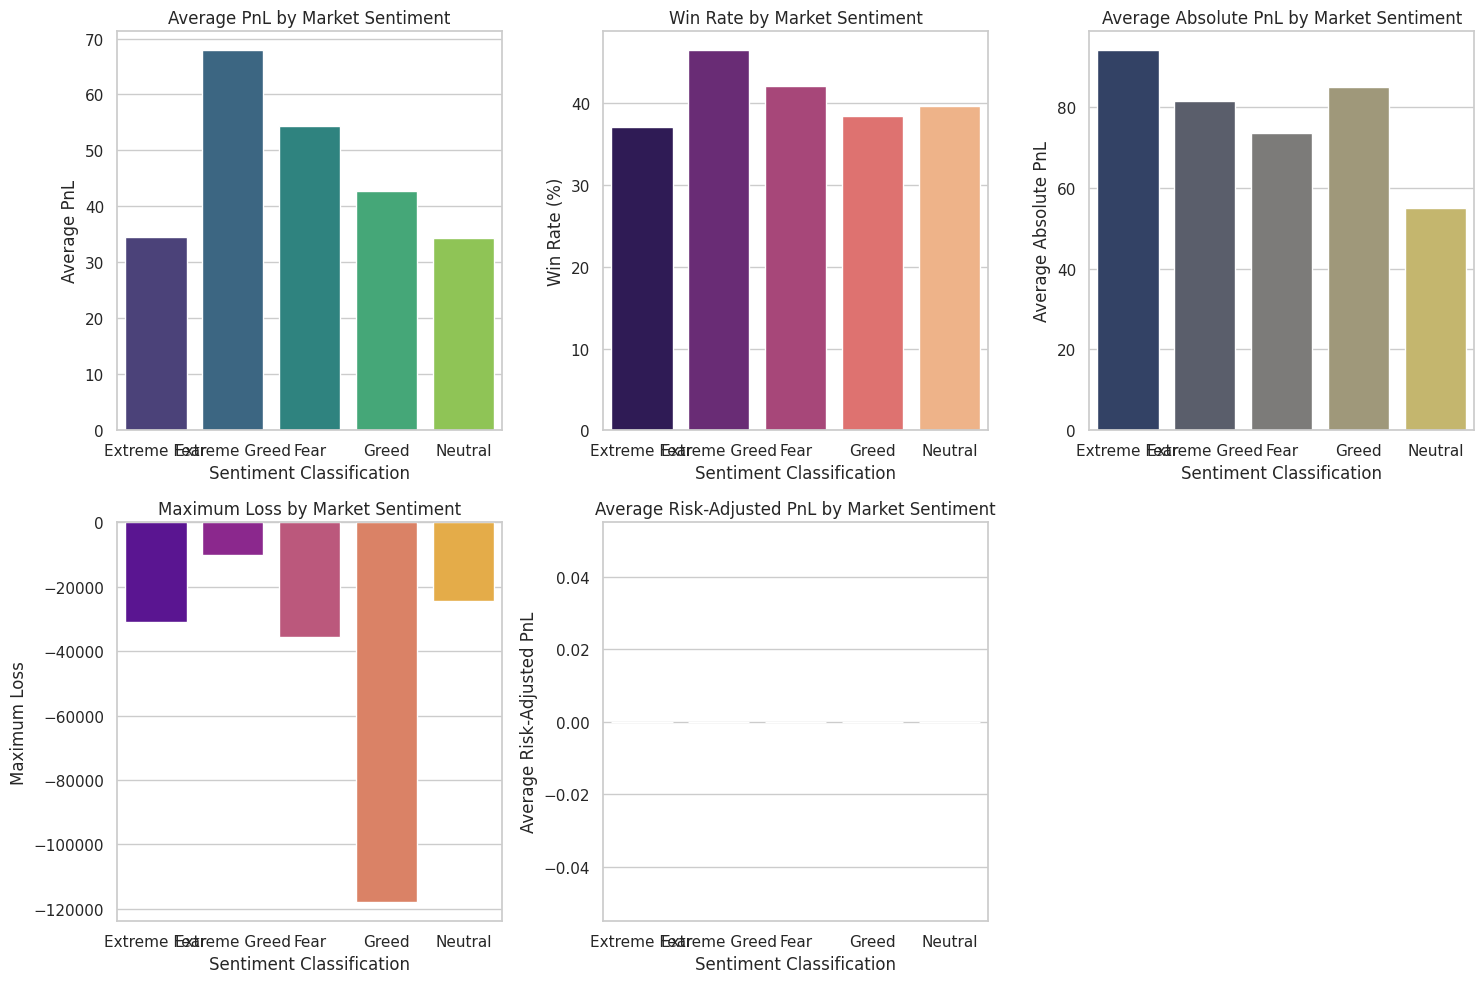

Visualizations generated successfully.


In [36]:
plt.figure(figsize=(15, 10))


plt.subplot(2, 3, 1) # 2 rows, 3 columns, 1st plot
sns.barplot(x='classification', y='avg_pnl', data=performance_summary, palette='viridis', hue='classification', legend=False)
plt.title('Average PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average PnL')


plt.subplot(2, 3, 2)
sns.barplot(x='classification', y='win_rate', data=performance_summary, palette='magma', hue='classification', legend=False)
plt.title('Win Rate by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Win Rate (%)')


plt.subplot(2, 3, 3)
sns.barplot(x='classification', y='avg_abs_pnl', data=risk_summary, palette='cividis', hue='classification', legend=False)
plt.title('Average Absolute PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Absolute PnL')


plt.subplot(2, 3, 4)
sns.barplot(x='classification', y='max_loss', data=risk_summary, palette='plasma', hue='classification', legend=False)
plt.title('Maximum Loss by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Maximum Loss')


plt.subplot(2, 3, 5)
sns.barplot(x='classification', y='avg_risk_adjusted_pnl', data=risk_summary, palette='coolwarm', hue='classification', legend=False)
plt.title('Average Risk-Adjusted PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Risk-Adjusted PnL')

plt.tight_layout()
plt.show()

print("Visualizations generated successfully.")